In [100]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import chart_studio.plotly as ply
import cufflinks as cf
from arch import arch_model
from tbats import BATS, TBATS
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (8,5)
import warnings
warnings.filterwarnings('ignore')


In [2]:
df_us = pd.read_csv('us.csv')

In [3]:
df_us.set_index('date', inplace = True)

In [4]:
df_us.shape

(244, 2)

In [5]:
df_us.head()

,cases,deaths
date,,
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0


<AxesSubplot:xlabel='date'>

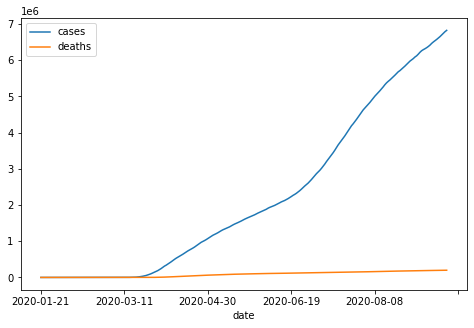

In [6]:
df_us.plot()

In [7]:
df_us['case_day'] = df_us['cases'].diff()
df_us['case_day'][0] = 1
df_us['case_day'] =  df_us['case_day'].astype('int')

In [8]:
df_us['case_day']

date
2020-01-21        1
2020-01-22        0
2020-01-23        0
2020-01-24        1
2020-01-25        1
              ...  
2020-09-16    39216
2020-09-17    45313
2020-09-18    48875
2020-09-19    41844
2020-09-20    36401
Name: case_day, Length: 244, dtype: int32

In [9]:
df_us['case_day'].describe()

count      244.000000
mean     27974.430328
std      20905.013735
min          0.000000
25%       8037.750000
50%      26623.000000
75%      43426.250000
max      75682.000000
Name: case_day, dtype: float64

<AxesSubplot:xlabel='date', ylabel='New Cases per Day'>

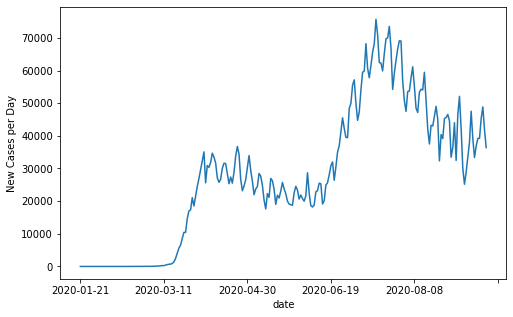

In [10]:
df_us['case_day'].plot(ylabel = 'New Cases per Day')


In [11]:
test = adfuller(df_us['case_day'])
test_cases_day = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_cases_day)
# P-value > 0.05 Not Stationary


Test Statstic                   -1.803998
p-value                          0.378478
#Lags Used                       0.000000
Number of Observations Used    243.000000
dtype: float64


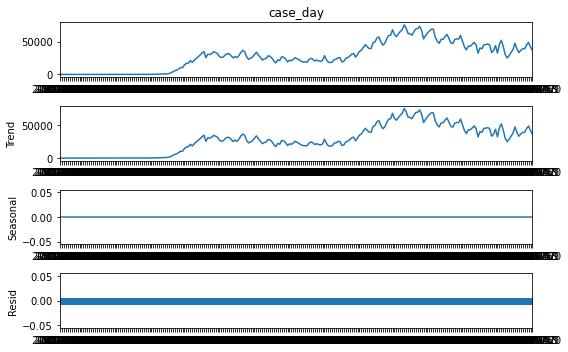

In [12]:
sd = seasonal_decompose(df_us['case_day'], model='additive', freq=1)
sd.plot()
pyplot.show()

## Differencing 


In [13]:
diff1 = df_us['case_day'] - df_us['case_day'].shift(1)

In [14]:
diff1 = diff1.dropna()

In [15]:
test = adfuller(diff1)
test_diff1 = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_diff1)
# pvalue still > 0.05 

Test Statstic                   -2.275090
p-value                          0.180128
#Lags Used                      14.000000
Number of Observations Used    228.000000
dtype: float64


In [16]:
diff2 = diff1 - diff1.shift(1)
diff2 = diff2.dropna()

In [17]:
test = adfuller(diff2)
test_diff2 = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_diff2)
# pvalue still > 0.05 

Test Statstic                 -7.537993e+00
p-value                        3.437494e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.280000e+02
dtype: float64


### p-value < 0.05 
Series stationary at d = 2

## Plotting ACF and PACF

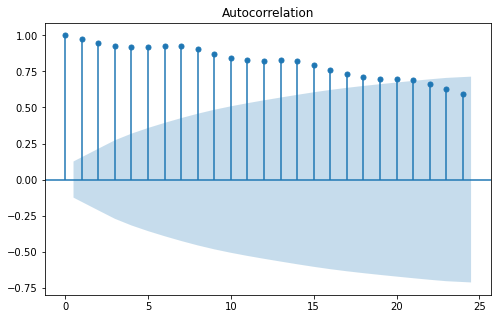

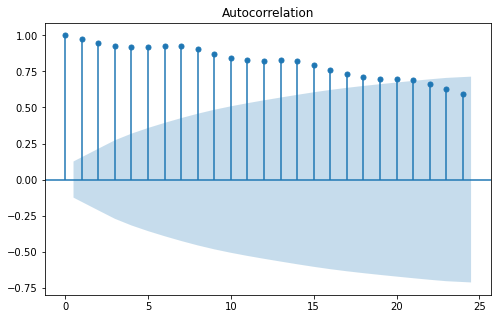

In [18]:
plot_acf(df_us['case_day'], alpha = 0.05) # q = 1-20

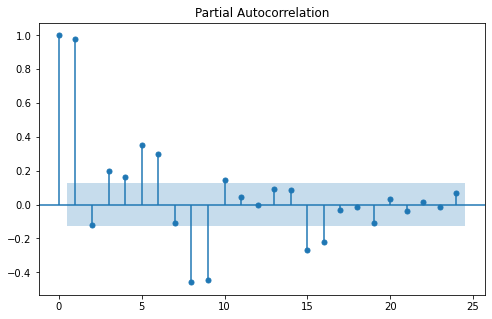

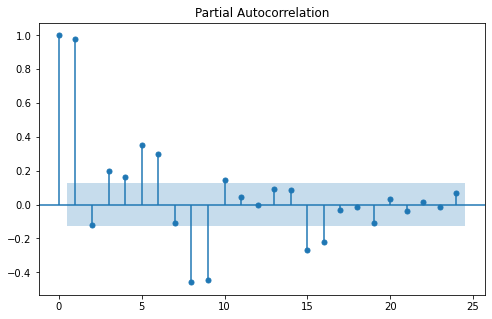

In [19]:
plot_pacf(df_us['case_day'], alpha = 0.05) # p = 3

## Train Test Split

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


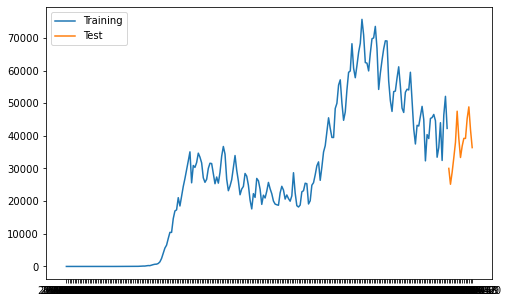

In [193]:
train = df_us['case_day'].loc['2020-01-21':'2020-09-05']
test = df_us['case_day'].loc['2020-09-06':]
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')
plt.show()

## BASELINE NAIVE

In [21]:
naive_preds = test.copy()
naive_preds.values[:] = train[len(train)-1]

In [22]:
naive_preds

date
2020-09-06    42278
2020-09-07    42278
2020-09-08    42278
2020-09-09    42278
2020-09-10    42278
2020-09-11    42278
2020-09-12    42278
2020-09-13    42278
2020-09-14    42278
2020-09-15    42278
2020-09-16    42278
2020-09-17    42278
2020-09-18    42278
2020-09-19    42278
2020-09-20    42278
Name: case_day, dtype: int32

In [23]:
naive_RMSE = np.sqrt(mean_squared_error(naive_preds, test))
print('Naive RMSE: ', naive_RMSE)

Naive RMSE:  8056.436222052527


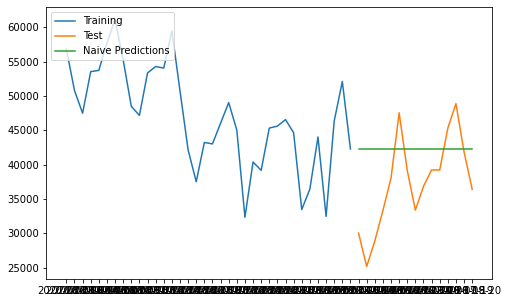

In [24]:

plt.plot(train.loc['2020-08-01':'2020-09-05'], label = 'Training')
plt.plot(test, label = 'Test')
plt.plot(naive_preds, label = 'Naive Predictions')
plt.legend(loc = 'upper left')
plt.show()

## ARIMA model

In [25]:
arima = ARIMA(train, order=(2, 2, 2))
arima_fit = arima.fit(disp= 0)
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.case_day   No. Observations:                  227
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -2183.376
Method:                       css-mle   S.D. of innovations           3609.183
Date:                Mon, 21 Sep 2020   AIC                           4378.752
Time:                        11:33:22   BIC                           4399.301
Sample:                    01-23-2020   HQIC                          4387.044
                         - 09-05-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.2530     22.727      0.055      0.956     -43.290      45.796
ar.L1.D2.case_day     0.7132      0.070     10.235      0.000       0.577       0.850
ar.L2.D2.case_day    -0.

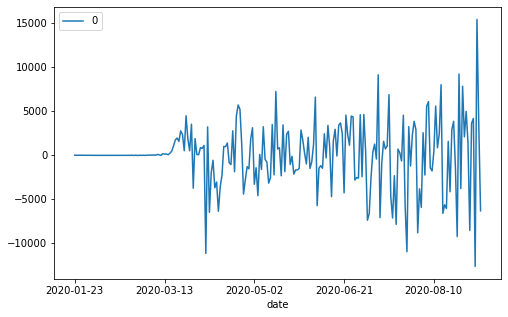

In [26]:
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot()
pyplot.show()

In [30]:
preds = arima_fit.forecast(steps = 15)[0]

In [31]:
preds

array([38363.66840285, 39532.85877425, 42060.04876133, 43604.97966522,
       43928.85161885, 43759.80579642, 43708.83054373, 43932.14062232,
       44306.58267637, 44684.35103226, 45007.31073684, 45290.74430661,
       45567.8699329 , 45856.5116869 , 46156.62883502])

In [32]:
np.sqrt(mean_squared_error(preds, test))

8076.825512983111

In [33]:
df_us['case_day'].describe()

count      244.000000
mean     27974.430328
std      20905.013735
min          0.000000
25%       8037.750000
50%      26623.000000
75%      43426.250000
max      75682.000000
Name: case_day, dtype: float64

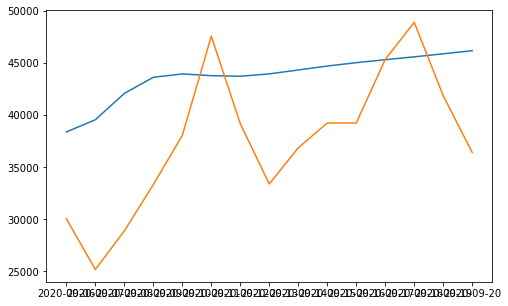

In [34]:
pyplot.plot(preds)
pyplot.plot(test)

### Grid Search for ARIMA

## ARIMA with best parameters

In [36]:
best_arima = ARIMA(train, order=(7, 1, 6))
best_arima_fit = best_arima.fit(disp= 0)


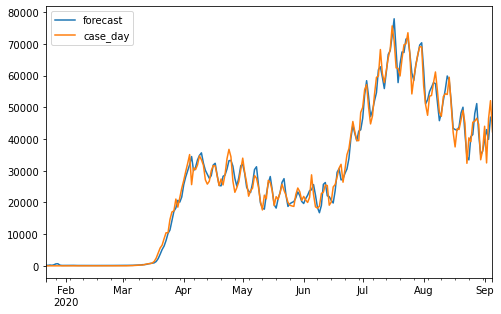

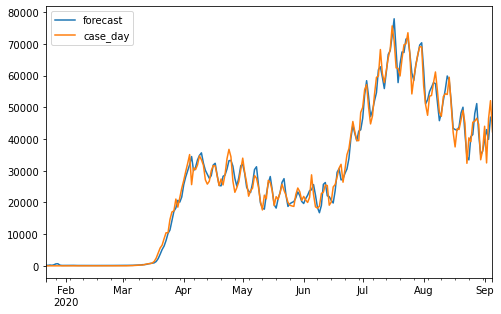

In [37]:
best_arima_fit.plot_predict()

In [42]:
preds = best_arima_fit.forecast(steps = 15)[0]

In [43]:
best_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.case_day   No. Observations:                  228
Model:                 ARIMA(7, 1, 6)   Log Likelihood               -2125.942
Method:                       css-mle   S.D. of innovations                nan
Date:                Mon, 21 Sep 2020   AIC                           4281.885
Time:                        11:35:11   BIC                           4333.325
Sample:                    01-22-2020   HQIC                          4302.639
                         - 09-05-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              185.4505        nan        nan        nan         nan         nan
ar.L1.D.case_day     0.3445   9.19e-06   3.75e+04      0.000       0.344       0.344
ar.L2.D.case_day    -0.1610        nan        nan        nan         nan         nan
ar.L3.D.case_day    -0.1997   1.81e-06   -1.1e+05      0.000      -0.200      -0.200
ar.L4.D.case_day     0.3565   1.61e-05   2.22e+04      0.000       0.356       0.357
ar.L5.D.case_day    -0.6319        nan        nan        nan         nan         nan
ar.L6.D.case_day     0.5774   4.03e-06   1.43e+05      0.000       0.577       0.577
ar.L7.D.case_day     0.3947        nan        nan        nan         nan         nan
ma.L1.D.case_day    -0.6916      0.049    -14.005      0.000      -0.788      -0.595
ma.L2.D.case_day     0.4061      0.048      8.546      0.000       0.313       0.499
ma.L3.D.case_day     0.0072      0.057      0.126      0.900      -0.105       0.120
ma.L4.D.case_day    -0.4339      0.041    -10.459      0.000      -0.515      -0.353
ma.L5.D.case_day     0.8711      0.062     14.010      0.000       0.749       0.993
ma.L6.D.case_day    -0.6281      0.054    -11.598      0.000      -0.734      -0.522
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0664           -0.0000j            1.0664           -0.0000
AR.2            0.6289           -0.7775j            1.0000           -0.1418
AR.3            0.6289           +0.7775j            1.0000            0.1418
AR.4           -0.2219           -0.9751j            1.0000           -0.2856
AR.5           -0.2219           +0.9751j            1.0000            0.2856
AR.6           -1.0247           -0.0000j            1.0247           -0.5000
AR.7           -2.3186           -0.0000j            2.3186           -0.5000
MA.1           -1.0180           -0.0000j            1.0180           -0.5000
MA.2           -0.1825           -0.9905j            1.0072           -0.2790
MA.3           -0.1825           +0.9905j            1.0072            0.2790
MA.4            0.7616           -0.8103j            1.1121           -0.1299
MA.5            0.7616           +0.8103j            1.1121            0.1299
MA.6            1.2467           -0.0000j            1.2467           -0.0000
-----------------------------------------------------------------------------
"""

In [44]:
best_rmse = np.sqrt(mean_squared_error(preds, test))
print('Best ARIMA RMSE: ',best_rmse)

Best ARIMA RMSE:  5528.68075986263


In [45]:
preds

array([36615.30462049, 36765.99442138, 39297.71359229, 39733.49376976,
       45984.27933713, 50194.65470207, 44271.73178117, 36772.61124462,
       37835.74510717, 39453.06556671, 40404.99501922, 46286.854246  ,
       51255.3063748 , 45126.20465173, 38071.54774187])

In [46]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36839
2020-09-15    39221
2020-09-16    39216
2020-09-17    45313
2020-09-18    48875
2020-09-19    41844
2020-09-20    36401
Name: case_day, dtype: int32

## AUTO ARIMA

In [ ]:
#test.iplot(title="Energy Production Jan 1985--Jan 2018")

In [47]:
model_auto = auto_arima(train, start_p=1, start_q=1, d = 1,
                           max_p=20, max_q=20, trace=True,
                       error_action='ignore',  m = 1,
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4423.556, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4425.618, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4427.290, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4427.136, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4424.126, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4408.291, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4420.824, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4404.840, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4418.403, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4378.172, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4384.094, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4365.103, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4364.313, Time=0.07 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=4361.554, Time=0.10 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept

In [48]:
model_auto_fit = model_auto.fit(train)

In [52]:
preds = model_auto_fit.predict(n_periods = 15)

In [53]:
preds

array([39438.41121831, 40670.07763697, 40429.15763704, 40462.23314101,
       45455.98581621, 52268.97728407, 45374.59972612, 40726.62829301,
       43000.62911724, 41370.526741  , 41714.88844695, 47930.48815925,
       50842.20812083, 47073.61603363, 42975.10291035])

In [54]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36839
2020-09-15    39221
2020-09-16    39216
2020-09-17    45313
2020-09-18    48875
2020-09-19    41844
2020-09-20    36401
Name: case_day, dtype: int32

In [55]:
rmse = np.sqrt(mean_squared_error(preds, test))
print('Auto ARIMA RMSE: ',rmse)

Auto ARIMA RMSE:  7366.130018488264


## Simple Exponential Smoothing(SES)

In [57]:
ses = SimpleExpSmoothing(train)
ses_fit = ses.fit()

In [58]:
ses_preds = ses_fit.forecast(steps = 15)

In [59]:
ses_preds

2020-09-06    42278.0
2020-09-07    42278.0
2020-09-08    42278.0
2020-09-09    42278.0
2020-09-10    42278.0
2020-09-11    42278.0
2020-09-12    42278.0
2020-09-13    42278.0
2020-09-14    42278.0
2020-09-15    42278.0
2020-09-16    42278.0
2020-09-17    42278.0
2020-09-18    42278.0
2020-09-19    42278.0
2020-09-20    42278.0
Freq: D, dtype: float64

In [60]:
np.sqrt(mean_squared_error(ses_preds, test))

8056.436222052527

## FBPROPHET

In [61]:
X = pd.DataFrame(train)

In [62]:
X.rename(columns = {'case_day':'y'}, inplace = True)
X.index.names = ['ds']
X.head()

,y
ds,
2020-01-21,1
2020-01-22,0
2020-01-23,0
2020-01-24,1
2020-01-25,1


In [63]:
X['index'] = np.arange(len(X))

In [64]:
X['ds'] = X.index

In [65]:
X.set_index('index', inplace = True)


In [66]:
model = Prophet()
model.fit(X)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [67]:
future = model.make_future_dataframe(periods = 15)
future.tail()

,ds
239,2020-09-16
240,2020-09-17
241,2020-09-18
242,2020-09-19
243,2020-09-20


In [68]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
239,2020-09-16,58619.074192,45860.745746,71491.625520
240,2020-09-17,61038.107513,49230.493862,73300.298994
241,2020-09-18,62552.992384,50188.674767,75271.390281
242,2020-09-19,59657.395325,46714.764367,71642.045299
243,2020-09-20,56047.588076,42738.449242,69614.593974


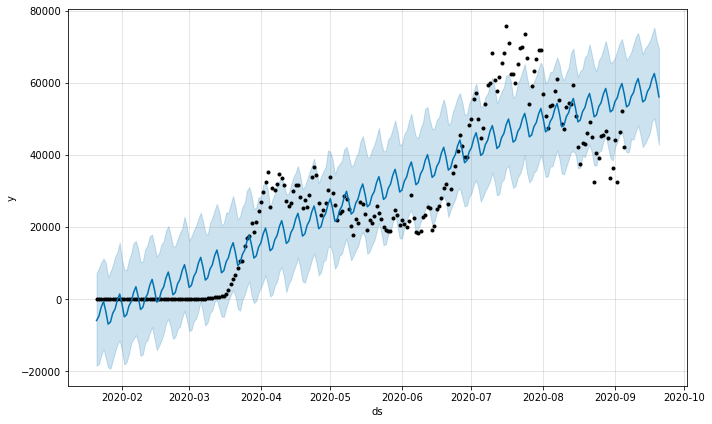

In [69]:
fig1 = model.plot(forecast)


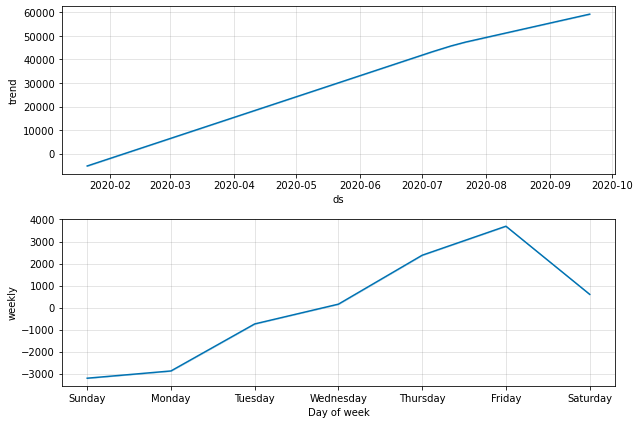

In [70]:
fig2 = model.plot_components(forecast)

In [71]:
#plot_plotly(model, forecast)

In [72]:
#plot_components_plotly(model, forecast)

In [74]:
np.sqrt(mean_squared_error(test, forecast['yhat'].tail(15)))


20549.567682080688

## TBATS

In [75]:
tbats = TBATS()
tbats_fit = tbats.fit(train)

In [78]:
preds_tbats = tbats_fit.forecast(steps = 15)

In [79]:
np.sqrt(mean_squared_error(test, preds_tbats))

11039.343188752451

In [80]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36839
2020-09-15    39221
2020-09-16    39216
2020-09-17    45313
2020-09-18    48875
2020-09-19    41844
2020-09-20    36401
Name: case_day, dtype: int32

In [81]:
preds_tbats

array([48534.49965928, 46243.61367383, 42872.92847179, 44862.45162456,
       45462.84611931, 47658.24003515, 48481.77819373, 47357.90360872,
       46284.20757588, 45848.4564317 , 46750.79737105, 48205.43210518,
       48963.64451147, 48663.37160373, 47769.05949731])

## Helper functions for NN models

In [224]:
# preparing data to features and target to feed to the model
def prepare_data(timeseries_data, n_steps):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [228]:
def make_predictions(model, num_days, n_steps):
    x_input = Y[-n_steps:]
    x_input = x_input.reshape(1, n_steps, n_features)
    preds = []
    i = 0
    while i < num_days:
        pred = model.predict(x_input)[0][0]
        preds.append(pred)
        x_input = np.append(x_input[0], pred)
        x_input = x_input[-n_steps:]
        x_input = x_input.reshape(1, n_steps, n_features)
        i += 1
    
    return preds

## DNN

In [467]:
n_steps = 20
X, Y = prepare_data(train, n_steps)

# reshaping X from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [468]:
dnn = Sequential()
dnn.add(Dense(32, input_shape=(n_steps, n_features), activation='relu'))
dnn.add(Dense(8, activation='relu'))
dnn.add(Dense(1))
dnn.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
dnn.fit(X,Y, epochs = 100, verbose=0 )

In [469]:
dnn_preds =  make_predictions(dnn, 15, n_steps)

In [470]:
dnn_preds

[array([37460.273], dtype=float32),
 array([43171.87], dtype=float32),
 array([42960.145], dtype=float32),
 array([45967.246], dtype=float32),
 array([48965.363], dtype=float32),
 array([44974.54], dtype=float32),
 array([32299.963], dtype=float32),
 array([40328.555], dtype=float32),
 array([39119.12], dtype=float32),
 array([45260.164], dtype=float32),
 array([45546.793], dtype=float32),
 array([46497.562], dtype=float32),
 array([44583.043], dtype=float32),
 array([33410.523], dtype=float32),
 array([36393.656], dtype=float32)]

In [471]:
np.sqrt(mean_squared_error(dnn_preds, test))

8687.596565530768

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


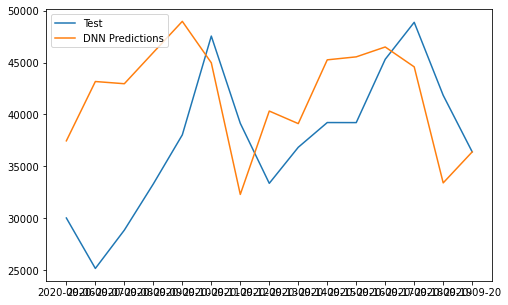

In [521]:
plt.plot(test, label = 'Test')
plt.plot(dnn_preds, label = 'DNN Predictions')
plt.legend(loc = 'upper left')
plt.show()

## RNN

In [478]:
n_steps = 15
X, Y = prepare_data(train, n_steps)

# reshaping X from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [479]:
rnn = Sequential()
rnn.add(SimpleRNN(32, input_shape=(n_steps, n_features), activation="relu"))
rnn.add(Dense(8, activation='relu'))
rnn.add(Dense(1))
rnn.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])

In [480]:
rnn_fit = rnn.fit(X,Y, epochs = 100, verbose=0)

In [481]:
rnn_preds =  make_predictions(rnn, 15, n_steps)

In [482]:
rnn_preds

[37604.277,
 41676.273,
 41066.914,
 39782.266,
 44204.46,
 49039.984,
 45277.48,
 38650.324,
 37123.113,
 39664.73,
 37730.637,
 44284.992,
 47451.414,
 42753.92,
 37813.938]

In [483]:
np.sqrt(mean_squared_error(rnn_preds, test))

6504.40094701478

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


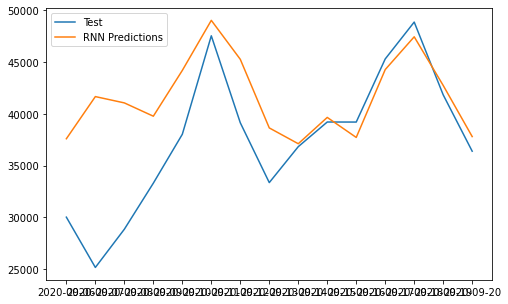

In [520]:
plt.plot(test, label = 'Test')
plt.plot(rnn_preds, label = 'RNN Predictions')
plt.legend(loc = 'upper left')
plt.show()

## LSTM

### Building a model

In [514]:
n_steps = 10
X, Y = prepare_data(train, n_steps)

# reshaping X from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [515]:
lstm = Sequential()
lstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
lstm.add(LSTM(50, activation='relu'))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse' ,metrics = ['mse', 'mae'])
# fit model
lstm.fit(X, Y, epochs= 100, verbose=0)

In [516]:
lstm_preds =  make_predictions(lstm, 15, n_steps)
lstm_preds

[40972.207,
 40205.055,
 38576.812,
 39451.17,
 44786.516,
 51433.395,
 42012.457,
 44142.324,
 41164.562,
 40826.758,
 41303.86,
 45055.945,
 41507.934,
 44067.344,
 44662.34]

In [517]:
np.sqrt(mean_squared_error(lstm_preds, test))

7374.826280817407

In [518]:
l_preds = test.copy()
l_preds.replace(l_preds.values, lstm_preds, inplace = True)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


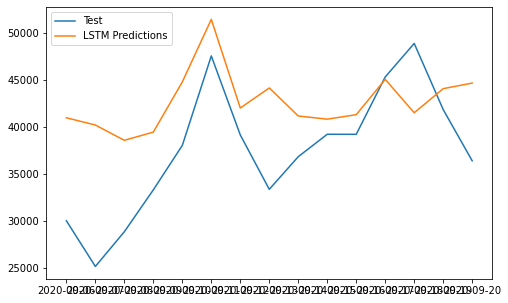

In [519]:
plt.plot(test, label = 'Test')
plt.plot(l_preds, label = 'LSTM Predictions')
plt.legend(loc = 'upper left')
plt.show()